### xdeepFM 模型


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding, Concatenate, Dropout, Input, Layer
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import os

In [9]:

def sparseFeature(feat, feat_num, embed_dim=4):
    """
    create dictionary for sparse feature
    :param feat: feature name
    :param feat_num: the total number of sparse features that do not repeat
    :param embed_dim: embedding dimension
    :return:
    """
    return {'feat': feat, 'feat_num': feat_num, 'embed_dim': embed_dim}

def denseFeature(feat):
    """
    create dictionary for dense feature
    :param feat: dense feature name
    :return:
    """
    return {'feat': feat}


def create_criteo_dataset(file_train, file_test, embed_dim=8, read_part=False, sample_num=100000, test_size=0.2):

    # 训练数据
    df_train = pd.read_csv(file_train)
    # 测试数据
    df_apply_new = pd.read_csv(file_test)
    # 合并训练集，验证集
    data_df = pd.concat([df_train, df_apply_new], axis=0, ignore_index=True)
    data_df['label'] = data_df['label'].fillna(str(-1))

    
    ### 增加几列
    # 增加六个维度
    data_df['province_sum'] = df_train.groupby(['province'])['label'].transform('sum')
    val = data_df['province'].value_counts()
    data_df['province_pre'] = data_df['province_sum'] / data_df['province'].apply(lambda x: val[x])

    data_df['city_sum'] = df_train.groupby(['city'])['label'].transform('sum')
    val = data_df['city'].value_counts()
    data_df['city_pre'] = data_df['city_sum'] / data_df['city'].apply(lambda x: val[x])

    data_df['model_sum'] = df_train.groupby(['model'])['label'].transform('sum')
    val = data_df['model'].value_counts()
    data_df['model_pre'] = data_df['model_sum'] / data_df['model'].apply(lambda x: val[x])
    
    
    
    # 稀疏特征 label 类型的特征 不需要归一化，非连续
    sparse_features = ['gender', 'province', 'city', 'make', 'model']
    # 稠密特征 需要归一化 连续性的特征
    dense_features = ['age', 'province_sum', 'city_sum', 'model_sum']


    def clean_data(string):
        # 对数据清洗
        string = re.sub(r"[^0-9()]", "", string)
        return string.strip().lower()


    # ==============Age ===================
    # 处理Age
    # 缺失值填充
    data_df['age'] = data_df['age'].fillna(-1)
    a = data_df['age'].copy()
    a = a.apply(lambda x: str(x).lower())
    # 统一字符类型转化成str()
    a = a.apply(lambda x: clean_data(x))
    data_df['age'] = a
    data_df['age'] = data_df['age'].astype('int')  # 转换数据类型为 int 类型


    # ==============appid_num ===================
    appid_num = data_df['appid']
    def get_appid_num(string):
        # 对数据清洗
        string = string.split(',')
        return len(string)

    appid_num = appid_num.apply(lambda x: get_appid_num(x))
    data_df['appid_num'] = appid_num
    dense_features = dense_features + ['appid_num']


    data_df[sparse_features] = data_df[sparse_features].fillna('-1')
    data_df[dense_features] = data_df[dense_features].fillna(0)

    
    
    # ==============gender ===================
    data_df['gender'] = data_df['gender'].astype('str')  # 转换数据类型为 int 类型


    for feat in sparse_features:
        le = LabelEncoder()
        data_df[feat] = le.fit_transform(data_df[feat])

        

    # ====================================================
    mms = MinMaxScaler(feature_range=(0, 1))
    data_df[dense_features] = mms.fit_transform(data_df[dense_features])

    
    dense_features = dense_features + ['province_pre', 'city_pre', 'model_pre']
    # 统计dense_features、sparse_features每个特征的个数和
    feature_columns = [[denseFeature(feat) for feat in dense_features]] + \
                      [[sparseFeature(feat, len(data_df[feat].unique()), embed_dim=embed_dim)
                        for feat in sparse_features]]

    # 划分训练集和测试集
    """
    ### 本次案例中：将所有的样本作为训练集。
    ### 使用全部的样本作为训练集，通过交叉验证的方法划分为：测试集+验证集
    """
    data_df_1 = data_df[:len(df_train)]  # data.click != -1的样本为训练的样本集合
    train, test = train_test_split(data_df_1, test_size=test_size)

    train_X = [train[dense_features].values.astype('int32'), train[sparse_features].values.astype('int32')]
    train_y = train['label'].values.astype('int32')
    test_X = [test[dense_features].values.astype('int32'), test[sparse_features].values.astype('int32')]
    test_y = test['label'].values.astype('int32')


    # 划分需要预测的样本集
    data_df_2 = data_df[-len(df_apply_new):]  # data.click == -1的样本为需要预测的样本集合
    total_test = [data_df_2[dense_features].values.astype('int32'), data_df_2[sparse_features].values.astype('int32')]

    return feature_columns, (train_X, train_y), (test_X, test_y), total_test

In [10]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # log输出信息  2 == ERROR（错误）

# you can modify your file path
file_train = '../data/train.csv'
file_test = '../data/apply_new.csv'


embed_dim = 12
read_part = True
sample_num = 6000000
test_size = 0.2

# ========================== Create dataset =======================
feature_columns, train, test, vail = create_criteo_dataset(file_train=file_train,
                                                           file_test=file_test,
                                                           embed_dim=embed_dim,
                                                           read_part=read_part,
                                                           sample_num=sample_num,
                                                           test_size=test_size)

F:\Python\1\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [11]:
feature_columns

[[{'feat': 'age'},
  {'feat': 'province_sum'},
  {'feat': 'city_sum'},
  {'feat': 'model_sum'},
  {'feat': 'appid_num'},
  {'feat': 'province_pre'},
  {'feat': 'city_pre'},
  {'feat': 'model_pre'}],
 [{'feat': 'gender', 'feat_num': 3, 'embed_dim': 12},
  {'feat': 'province', 'feat_num': 34, 'embed_dim': 12},
  {'feat': 'city', 'feat_num': 316, 'embed_dim': 12},
  {'feat': 'make', 'feat_num': 1549, 'embed_dim': 12},
  {'feat': 'model', 'feat_num': 129, 'embed_dim': 12}]]

In [17]:
class DNN(layers.Layer):
    """
    DNN part
    """
    def __init__(self, hidden_units, dnn_dropout=0., dnn_activation='relu'):
        """
        DNN为 n 层线性层，论文里也说是 plain DNN
        :param hidden_units: A list. list of hidden layer units's numbers.
        :param dnn_dropout: A scalar. dropout number.
        :param dnn_activation: A string. activation function.
        """
        super(DNN, self).__init__()
        self.dnn_network = [Dense(units=unit, activation=dnn_activation) for unit in hidden_units]
        self.dropout = Dropout(dnn_dropout)

    def call(self, inputs, **kwargs):
        x = inputs
        for dnn in self.dnn_network:
            x = dnn(x)
        x = self.dropout(x)
        return x


class Linear(layers.Layer):
    """
        线性层
    """
    def __init__(self):
        super(Linear, self).__init__()
        self.dense = Dense(1, activation=None)

    def call(self, inputs, **kwargs):
        result = self.dense(inputs)
        return result


class CIN(layers.Layer):
    """
    CIN part 核心内容
    """
    def __init__(self, cin_size, l2_reg=1e-4):
        """
        :param cin_size: A list. [H_1, H_2 ,..., H_k], a list of the number of layers
        :param l2_reg: A scalar. L2 regularization.
        """
        super(CIN, self).__init__()
        self.cin_size = cin_size
        self.l2_reg = l2_reg

    def build(self, input_shape):
        # 构建CIN
        self.embedding_nums = input_shape[1]
        # a list of the number of CIN
        self.field_nums = [self.embedding_nums] + self.cin_size
        # filters 可以看出这里没有共享参数
        self.cin_W = {
            'CIN_W_' + str(i): self.add_weight(
                name='CIN_W_' + str(i),
                shape=(1, self.field_nums[0] * self.field_nums[i], self.field_nums[i + 1]),
                initializer='random_uniform',
                regularizer=l2(self.l2_reg),
                trainable=True)
            for i in range(len(self.field_nums) - 1)
        }

    def call(self, inputs, **kwargs):
        dim = inputs.shape[-1]  # dim==8
        hidden_layers_results = [inputs] 
        # split dimension 2 for convenient calculation
        split_X_0 = tf.split(hidden_layers_results[0], dim, 2)  # dim * (None, field_nums[0], 1)

        # 迭代实现每一层的计算 注意 cin_size是个list 值是H_k
        for idx, size in enumerate(self.cin_size):
            # dim * (None, filed_nums[i], 1)
            # 计算 x_k X_k是
            split_X_K = tf.split(hidden_layers_results[-1], dim, 2)  
            # (dim, None, field_nums[0], field_nums[i])
            result_1 = tf.matmul(split_X_0, split_X_K, transpose_b=True)  
            result_2 = tf.reshape(result_1, shape=[dim, -1, self.embedding_nums * self.field_nums[idx]])
            # (None, dim, field_nums[0] * field_nums[i])
            result_3 = tf.transpose(result_2, perm=[1, 0, 2]) 
            # 这一步是论文里的公式6
            result_4 = tf.nn.conv1d(input=result_3, filters=self.cin_W['CIN_W_' + str(idx)], stride=1,
                                    padding='VALID')
            # (None, field_num[i+1], dim)
            result_5 = tf.transpose(result_4, perm=[0, 2, 1])  
            # 这一步得到了x_K
            hidden_layers_results.append(result_5)

        final_results = hidden_layers_results[1:]
        # (None, H_1 + ... + H_K, dim)
        result = tf.concat(final_results, axis=1)
        # (None, dim)
        result = tf.reduce_sum(result,  axis=-1)  

        return result


class xDeepFM(keras.Model):
    def __init__(self, feature_columns, hidden_units, cin_size, dnn_dropout=0, dnn_activation='relu',
                 embed_reg=1e-5, cin_reg=1e-5):
        """
        xDeepFM
        :param feature_columns: A list. a list containing dense and sparse column feature information.
        :param hidden_units: A list. a list of dnn hidden units.
        :param cin_size: A list. a list of the number of CIN layers.
        :param dnn_dropout: A scalar. dropout of dnn.
        :param dnn_activation: A string. activation function of dnn.
        :param embed_reg: A scalar. the regularizer of embedding.
        :param cin_reg: A scalar. the regularizer of cin.
        """
        super(xDeepFM, self).__init__()
        # 读入特征 包括稠密特征和稀疏特征
        self.dense_feature_columns, self.sparse_feature_columns = feature_columns
        # 稀疏特征的嵌入维度 默认 8
        self.embed_dim = self.sparse_feature_columns[0]['embed_dim']
        self.embed_layers = {
            'embed_' + str(i): Embedding(input_dim=feat['feat_num'],
                                         input_length=1,
                                         output_dim=feat['embed_dim'],
                                         embeddings_initializer='random_uniform',
                                         embeddings_regularizer=l2(embed_reg))
            for i, feat in enumerate(self.sparse_feature_columns)
        }
        # 线性层
        self.linear = Linear()
        # CIN模块
        self.cin = CIN(cin_size=cin_size, l2_reg=cin_reg)
        # DNN模块
        self.dnn = DNN(hidden_units=hidden_units, dnn_dropout=dnn_dropout, dnn_activation=dnn_activation)
        # CIN的输出层
        self.cin_dense = Dense(1)
        # DNN的输出层
        self.dnn_dense = Dense(1)
        # 共享的偏差
        self.bias = self.add_weight(name='bias', shape=(1, ), initializer=tf.zeros_initializer())

    def call(self, inputs, **kwargs):
        # 首先分开稀疏和稠密特征
        dense_inputs, sparse_inputs = inputs
        # 对特征做嵌入
        embed = [self.embed_layers['embed_{}'.format(i)](sparse_inputs[:, i]) for i in range(sparse_inputs.shape[1])]

        # cin部分
        # 此处需要一步三维矩阵转置，0和1维度互换
        embed_matrix = tf.transpose(tf.convert_to_tensor(embed), [1, 0, 2]) # (None, 26, 8)
        cin_out = self.cin(embed_matrix)  # (None, embedding_nums, dim)
        cin_out = self.cin_dense(cin_out)

        # dnn部分
        embed_vector = tf.reshape(embed_matrix, shape=(-1, embed_matrix.shape[1] * embed_matrix.shape[2]))
        dnn_out = self.dnn(embed_vector)
        dnn_out = self.dnn_dense(dnn_out)

        # Linear部分
        wide_out = self.linear(embed_vector)

        # sigmoid激活转化为点击率
        # output = tf.nn.sigmoid(cin_out + dnn_out + self.bias)
        output = tf.nn.sigmoid(cin_out + dnn_out + wide_out)
        return output

    def summary(self):
        # 记录模型结构
        dense_inputs = Input(shape=(len(self.dense_feature_columns),), dtype=tf.float32)
        sparse_inputs = Input(shape=(len(self.sparse_feature_columns),), dtype=tf.int32)
        keras.Model(inputs=[dense_inputs, sparse_inputs], outputs=self.call([dense_inputs, sparse_inputs])).summary()

In [18]:
read_part = True
sample_num = 6000000
test_size = 0.2

embed_dim = 8
dnn_dropout = 0.5
hidden_units = [256, 128, 64]
cin_size = [128, 128]

learning_rate = 0.001
batch_size = 256
epochs = 30

# ========================== Create dataset =======================
train_X, train_y = train
test_X, test_y = test

# ============================Build Model==========================
model = xDeepFM(feature_columns, hidden_units, cin_size)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_5 (Te [(None,)]            0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_6 (Te [(None,)]            0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_7 (Te [(None,)]            0           input_4[0][0]                    
____________________________________________________________________________________________

In [19]:
# ============================Compile============================
model.compile(loss=binary_crossentropy, 
              optimizer=Adam(learning_rate=learning_rate),
              metrics=[AUC()])
# ==============================Fit==============================
history = model.fit(
    train_X,
    train_y,
    epochs=epochs,
    callbacks=[EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)],  # checkpoint
    batch_size=batch_size,
    validation_split=0.1
)
# ===========================Test==============================
print('test AUC: %f' % model.evaluate(test_X, test_y)[1])

Train on 216000 samples, validate on 24000 samples
Epoch 1/30


F:\Python\1\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


F:\Python\1\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


216000/216000 [==============================] - 35s 162us/sample - loss: 0.6132 - auc_1: 0.7050 - val_loss: 0.6058 - val_auc_1: 0.7143
Epoch 2/30
216000/216000 [==============================] - 32s 149us/sample - loss: 0.6029 - auc_1: 0.7183 - val_loss: 0.6044 - val_auc_1: 0.7162
Epoch 3/30
216000/216000 [==============================] - 33s 154us/sample - loss: 0.6013 - auc_1: 0.7207 - val_loss: 0.6044 - val_auc_1: 0.7166
Epoch 4/30
216000/216000 [==============================] - 34s 158us/sample - loss: 0.5999 - auc_1: 0.7228 - val_loss: 0.6045 - val_auc_1: 0.7165
60000/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================

test AUC: 0.715868


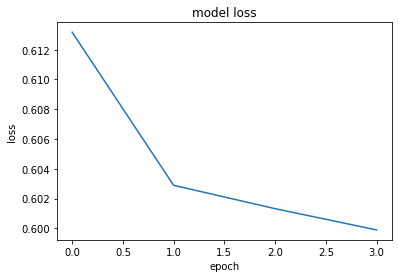

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

参考博客：model.predict 二分类 <br>
https://zhuanlan.zhihu.com/p/79390766 <br>
https://blog.csdn.net/xiaocxyczh/article/details/85226639 <br>
y_pred = model.predict_classes(X_test, batch_size = 20, verbose = 1)


In [21]:
pre_data = model.predict(vail)
pre_data

array([[4.7640502e-01],
       [2.7350456e-01],
       [3.7421378e-01],
       ...,
       [6.0884690e-01],
       [6.3785911e-04],
       [3.5139918e-04]], dtype=float32)

In [22]:
# 读入文件并写入预测值
label_submission = pd.read_csv('../data/submit_sample.csv')
label_submission.head()

,user_id,category_id
0,1400001,0
1,1400002,1
2,1400003,0
3,1400004,0
4,1400005,0


In [23]:
threshold = 0.5
result = []
for pred in pre_data:
    result.append(1 if pred > threshold else 0)

In [24]:
result

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [25]:
label_submission['category_id'] = result

In [26]:
label_submission

,user_id,category_id
0,1400001,0
1,1400002,0
2,1400003,0
3,1400004,0
4,1400005,1
...,...,...
99995,1499996,0
99996,1499997,0
99997,1499998,1
99998,1499999,0


In [27]:
label_submission.to_csv("../submission/submission_xdeepFM.csv",index=False)